In [3]:
# Peak analysis of the job data

from matplotlib.ticker import MultipleLocator, FixedLocator, LogLocator, NullFormatter, ScalarFormatter
from matplotlib.pyplot import MultipleLocator
from datetime import date, datetime, time, timedelta
import os
import numpy as np
import pandas as pd
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import time, datetime, pytz
import re

In [175]:
file_path = "/Users/chuxiaoyu/VScodeProjects/SURFJob/"
data = pd.read_csv(file_path + "slurm_data_2022_cleaned.csv")
data = data.loc[:,['Submit', 'state']]
data.head()

/Users/chuxiaoyu/Applications/anaconda3/envs/py3.8/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning:

Columns (17,18,19,20,21,22) have mixed types.Specify dtype option on import or set low_memory=False.



,Submit,state
0,2022-01-01 01:55:55,COMPLETED
1,2022-01-01 03:49:53,COMPLETED
2,2022-01-01 04:19:20,TIMEOUT
3,2022-01-01 04:32:24,CANCELLED
4,2022-01-01 04:47:23,COMPLETED


In [182]:
# Time granularity: Month, Week, Day, Hour
data['Submit'] = pd.to_datetime(data['Submit'], format = '%Y-%m-%d %H:%M:%S')
data['day'] = data['Submit'].dt.date
data['month'] = data['day'].apply(lambda x: str(x)[:7])
def dt_to_week(df):
    l = []
    for i in df['Submit']:
        j = i.strftime("%W")
        l.append(j)
    df['week'] = l
    return df
def dt_to_day(df):
    l = []
    for i in df['Submit']:
        j = i.strftime("%j")
        l.append(j)
    df['day'] = l
    return df
data = dt_to_week(data)
data = dt_to_day(data)
data

,Submit,state,day,month,week
0,2022-01-01 01:55:55,COMPLETED,001,2022-01,00
1,2022-01-01 03:49:53,COMPLETED,001,2022-01,00
2,2022-01-01 04:19:20,TIMEOUT,001,2022-01,00
3,2022-01-01 04:32:24,CANCELLED,001,2022-01,00
4,2022-01-01 04:47:23,COMPLETED,001,2022-01,00
...,...,...,...,...,...
2301123,2022-12-31 22:44:37,COMPLETED,365,2022-12,52
2301124,2022-12-31 22:44:37,COMPLETED,365,2022-12,52
2301125,2022-12-31 23:05:42,COMPLETED,365,2022-12,52
2301126,2022-12-31 23:05:42,COMPLETED,365,2022-12,52


In [184]:
# df_month
group = data.groupby(["month"])
failL = []
for i in group:
    a = i[1]['state'].value_counts().to_frame()
    fail = a.loc['FAILED','state']
    failL.append(fail)
df_month = pd.DataFrame({
    "month": [1,2,3,4,5,6,7,8,9,10,11,12],
    "failed": failL
})

# df_week
group = data.groupby(["week"])
failL, iL = [], []
for i in group:
    a = i[1]['state'].value_counts().to_frame()
    fail = a.loc['FAILED','state']
    failL.append(fail)
    iL.append(i[0])

df_week = pd.DataFrame({
    "week": iL,
    "failed": failL
})

# df_day
group = data.groupby(["day"])
failL, iL = [], []
for i in group:
    a = i[1]['state'].value_counts().to_frame()
    fail = a.loc['FAILED','state']
    failL.append(fail)
    iL.append(i[0])

df_day = pd.DataFrame({
    "day": iL,
    "failed": failL
})

In [210]:
# Remove Outlier in Resource data
def three_sigma(ser1): 
    # 求平均值
    mean_value = ser1.mean()
    # 求标准差
    std_value = ser1.std()
    # 位于(μ-3σ,μ+3σ)区间的数据是正常的，不在这个区间的数据为异常的
    # ser1中的数值小于μ-3σ或大于μ+3σ均为异常值
    # 一旦发现有异常值，就标注为True，否则标注为False
    rule = (mean_value - 3 * std_value > ser1) | \
                                                   (ser1.mean() + 3 * ser1.std() < ser1)
    # 返回异常值的位置索引
    index = np.arange(ser1.shape[0])[rule]
    # 获取异常数据
    outrange = ser1.iloc[index]
    ser1.replace(to_replace=outrange, value=np.nan)
    return index, outrange

index, outrange_week = three_sigma(df_week['failed'])
df_week.replace(to_replace=outrange_week, value=np.nan)
outrange_day = three_sigma(df_day['failed'])
df_day.replace(to_replace=outrange_day, value=np.nan)
# print(df1, df2, df3)

ValueError: Series.replace cannot use dict-like to_replace and non-None value

In [209]:
df_week

,week,failed
0,00,27
1,01,1771
2,02,2864
3,03,2387
4,04,2951
5,05,2276
6,06,1604
7,07,1464
8,08,2561
9,09,1852


In [187]:
df_day.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   day     365 non-null    object
 1   failed  365 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 5.8+ KB


In [166]:
df_day["normalized"] = (df_day["failed"] - df_day["failed"].min()) / (df_day["failed"].max() - df_day["failed"].min())

In [221]:
# day failures
import plotly.express as px
# df_day_new = df_day.drop(df_day[df_day['failed']>900].index)
# df_day["failed"] = (df_day["failed"] - df_day["failed"].min()) / (df_day["failed"].max() - df_day["failed"].min())
fig = px.line(df_day, x='day', y='failed',
              labels=({'Failures per day': 'Failures per day', 'Day': 'Day'}))
 
fig.update_layout(template="simple_white", font=dict(size=12),
                  width=650,
                  xaxis_title = 'Failures per day',
                  yaxis_title = 'Day',
                  title_x=0.5, height=250)

In [ ]:
# [TODO] normalize

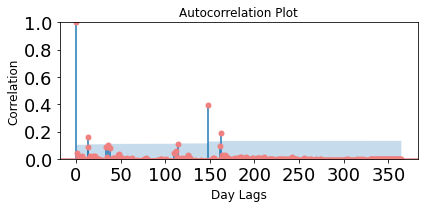

In [230]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
 
# Plot autocorrelation
plt.rc("figure", figsize=(6,3))
plot_acf(df_day['failed'], lags=364, color='lightcoral')
plt.ylim(0,1)
plt.xlabel('Day Lags', fontsize=12)
plt.ylabel('Correlation', fontsize=12)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title('Autocorrelation Plot', fontsize=12)
plt.tight_layout()
plt.show()

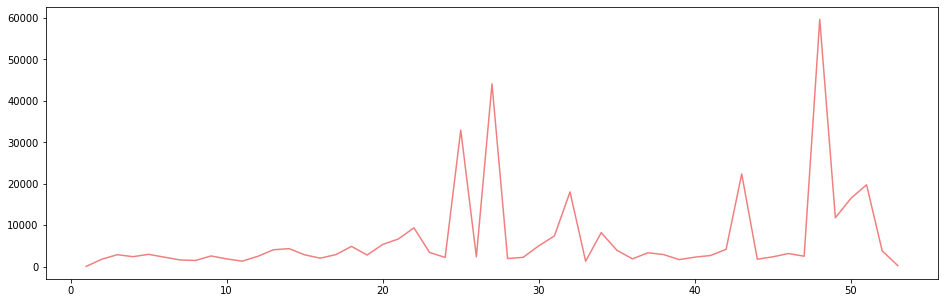

In [229]:
# line chart
fig = plt.figure(figsize=(16, 5))
x = range(1,54)
y = df_week['failed']
plt.plot(x,y,color='lightcoral')
plt.show()

In [164]:
# week failures
import plotly.express as px
df_week = df_week.drop(df_week[df_week['failed']>5000].index)
fig = px.line(df_week, x='week', y='failed',
              labels=({'Failed': 'failed', 'Day': 'day'}))
 
fig.update_layout(template="simple_white", font=dict(size=12),
                  title_text='Week failures', width=650,
                  xaxis_title = 'Failures per week',
                  yaxis_title = 'Week',
                  title_x=0.5, height=250)

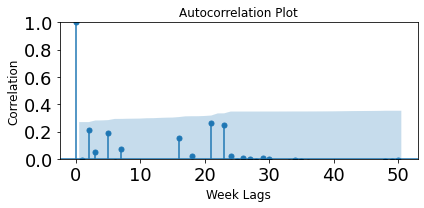

In [212]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt
 
# Plot autocorrelation
plt.rc("figure", figsize=(6,3))
plot_acf(df_week['failed'], lags=50)
plt.ylim(0,1)
plt.xlabel('Week Lags', fontsize=12)
plt.ylabel('Correlation', fontsize=12)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title('Autocorrelation Plot', fontsize=12)
plt.tight_layout()
plt.show()

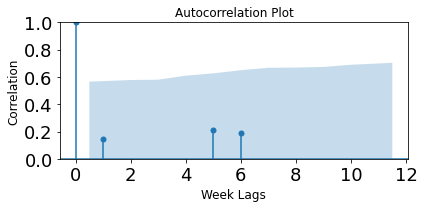

In [215]:
# Plot autocorrelation
plt.rc("figure", figsize=(6,3))
plot_acf(df_month['failed'], lags=11)
plt.ylim(0,1)
plt.xlabel('Week Lags', fontsize=12)
plt.ylabel('Correlation', fontsize=12)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title('Autocorrelation Plot', fontsize=12)
plt.tight_layout()
plt.show()